In [ ]:
library(BioStatR)
library(dplyr)
library(igraph)
library(geosphere)
library(ggplot2)
library(hexbin)

## Nodes

In [2]:
# Load the data
files <- list.files("../../data/task_44/networks")
files <- files[grep("^[A-Za-z]{3}_nodes.csv$|^[A-Za-z]{3}_edges.csv$", files)]
countries <- unique(sub("_nodes.csv$|_edges.csv$", "", files))

In [3]:
res <- data.frame()

for (country in countries){
  # Load and select nodes and edges
  nodes <- read.csv(paste0("../../data/task_44/networks/", country, "_nodes.csv"))
  nodes <- nodes |> select(nodeID, longitude, latitude)
  edges <- read.csv(paste0("../../data/task_44/networks/", country, "_edges.csv"))
  edges <- edges |> filter(nodeID_from >= nodeID_to) |> select(nodeID_from, nodeID_to, weight)

  # Create the graph
  g <- graph_from_data_frame(edges, directed = FALSE, vertices = nodes)

  n_nodes <- vcount(g)
  diameter <- diameter(g) # equal to 1 for complete graphs
  betweenness <- mean(betweenness(g, directed = FALSE, weights = E(g)$weight))
  clustering <- mean(transitivity(g, type = "weighted"))
  entropy <- mean(diversity(g, weights = E(g)$weights))
  mean_dist <- mean_distance(g,weights = E(g)$weights)
  

  res <- rbind(res, 
         data.frame(country = country, n_nodes = n_nodes, 
                    diameter = diameter, betweenness = betweenness, 
                    clustering = clustering, entropy = entropy, mean_dist = mean_dist))
  
}

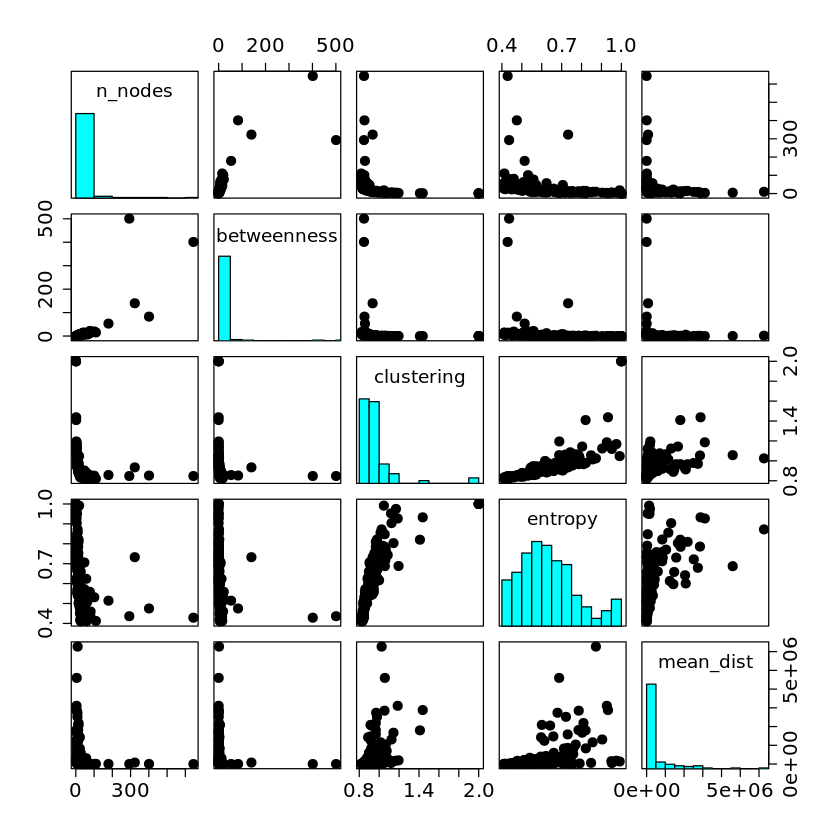

In [4]:
pairs(
  res |> select(-country, -diameter), 
  pch = 19, 
  diag.panel = panel.hist, 
  cex = 1.5,      
  cex.labels = 1.4,
  cex.axis = 1.5,
)

## Full world SCI

In [5]:
edges <- read.csv("../../data/task_44/networks/full_world_edges.csv")
nodes <- read.csv("../../data/task_44/networks/full_world_nodes.csv")

In [6]:
edges_dist <- edges |>
  inner_join(nodes, by = c("nodeID_from" = "nodeID")) |>
  rename(latitude_from = latitude, longitude_from = longitude) |>
  select(nodeID_from, nodeID_to, weight, latitude_from, longitude_from) |>
  inner_join(nodes, by = c("nodeID_to" = "nodeID")) |>
  rename(latitude_to = latitude, longitude_to = longitude) |>
  select(nodeID_from, nodeID_to, weight, latitude_from, longitude_from, latitude_to, longitude_to) |>
  mutate(distance = distHaversine(cbind(longitude_from, latitude_from), cbind(longitude_to, latitude_to))) |>
  select(-latitude_from, -longitude_from, -latitude_to, -longitude_to) |>
  filter(nodeID_from < nodeID_to) # Avoid duplicates and self-loops

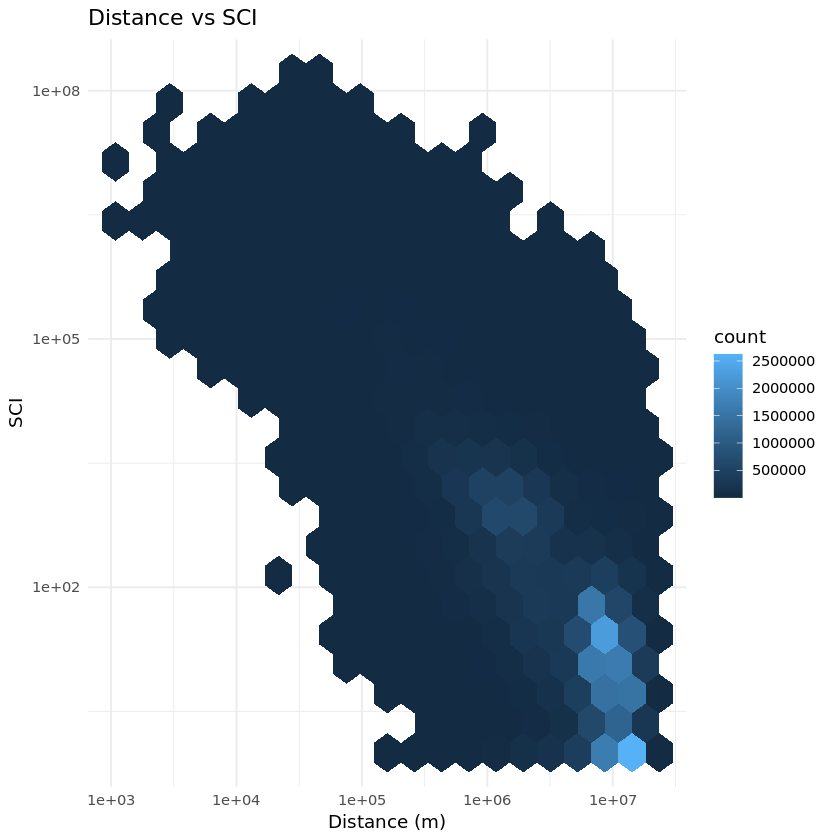

In [7]:
ggplot(edges_dist, aes(x = distance, y = weight)) + 
      geom_hex(bins = 20) +
      scale_x_log10() +
      scale_y_log10() +
      xlab("Distance (m)") +
      ylab("SCI") +
      ggtitle("Distance vs SCI") +
      theme_minimal()